<a href="https://colab.research.google.com/github/sominshim/Predicting_Personality_through_Text/blob/somin/Modeling_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# !pip install tensorflow-hub
# !pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

버전:  2.3.0
즉시 실행 모드:  True
허브 버전:  0.10.0
GPU 사용 불가능


In [2]:
# import module
import io
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.random.seed(42)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [5]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/mbti_1.csv'

In [7]:
#pandas read_csv로 불러오기
data = pd.read_csv(filename)
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


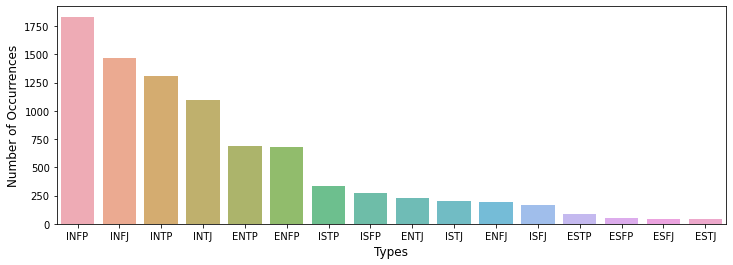

In [8]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [9]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [10]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'E':0, 'I':1, 'S':0, 'N':1, 'T':0, 'F':1, 'J':0, 'P':1}
b_Pers_list = [{'E':0, 'I':1}, {'S':0, 'N':1}, {'T':0, 'F':1}, {'J':0, 'P':1}]

#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 1 0]
 [0 1 0 1]
 [1 1 0 1]
 ...
 [1 1 0 1]
 [1 1 1 1]
 [1 1 1 1]]


In [11]:
data['E-I'] = list_personality_bin[:,0]
data['S-N'] = list_personality_bin[:,1]
data['T-F'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [12]:
data.head()

,type,posts,E-I,S-N,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0


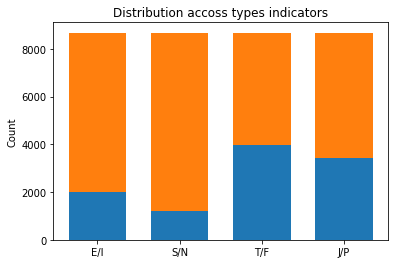

In [13]:
N = 4
but = (data['E-I'].value_counts()[0], data['S-N'].value_counts()[0], data['T-F'].value_counts()[0], data['J-P'].value_counts()[0])
top = (data['E-I'].value_counts()[1], data['S-N'].value_counts()[1], data['T-F'].value_counts()[1], data['J-P'].value_counts()[1])

ind = np.arange(N)    
width = 0.7      

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('E/I',  'S/N', 'T/F', 'J/P',))

plt.show()

In [16]:
print ("Introversion (I) /  Extroversion (E):\t", data['E-I'].value_counts()[0], " / ", data['E-I'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['S-N'].value_counts()[0], " / ", data['S-N'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", data['T-F'].value_counts()[0], " / ", data['T-F'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", data['J-P'].value_counts()[0], " / ", data['J-P'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Thinking (T) – Feeling (F):		 3981  /  4694
Judging (J) – Perceiving (P):		 3434  /  5241


## 데이터 전처리

In [18]:
from sklearn.preprocessing import LabelBinarizer
import re
import string

In [19]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'I\'m', 'I am'),(r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replace(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

text_replace = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_replace['TextBefore'] = data['posts'].copy()

In [20]:
for index, row in text_replace.iterrows():
    row['TextAfter'] = replace(row['TextBefore'])

In [21]:
print(text_replace['TextBefore'][:5],'\n->\n', text_replace['TextAfter'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: TextBefore, dtype: object 
->
 0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object


### 특수문자 제거

In [22]:
def cleaner(post):
    # 소문자 변환
    post = post.lower() 
    
    # '|||' 제거
    post = post.replace('|||', "") 

    # URL, 링크 등 특수문자 제거
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 

    # 구두점 제거
    post = post.translate(str.maketrans('', '', string.punctuation))

    # 공백 제거
    post = re.sub( '\s+', ' ', post ).strip()

    # MBTI 제거
    post = re.sub('infj|entp|intp|intj|entj|enfj|infp|enfp|isfp|istp|isfj|istj|estp|esfp|estj|esfj',"", post)

    # 길이가 짧은 단어 제거
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    post = shortword.sub('', post)
    
    return post

In [23]:
posts = text_replace.TextAfter.tolist()
posts = [cleaner(post) for post in posts]
data['clean_post'] = posts

In [24]:
print(text_replace['TextAfter'][:5],'\n->\n', data['clean_post'][:5])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I am finding the lack of me in these posts ve...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You are fired.|||That is another silly miscon...
Name: TextAfter, dtype: object 
->
 0    and  moments sportscenter not top ten plays pr...
1     finding the lack these posts very alarmingsex...
2    good one course which say know that blessing a...
3    dear enjoyed our conversation the other day es...
4    you are firedthat another silly misconception ...
Name: clean_post, dtype: object


### Remove Stopwords


In [25]:
# Remove Stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')

from nltk.stem import WordNetLemmatizer, PorterStemmer

n=WordNetLemmatizer()
s = PorterStemmer()

def tokenize(text):
    finalTokens = []
    tokens = nltk.word_tokenize(text)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    lem  = [n.lemmatize(w) for w in finalTokens]
    stem = [s.stem(w) for w in lem]
    text = " ".join(stem)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [26]:
text_removeStopwords = pd.DataFrame(columns=['TextBefore', 'TextAfter'])
text_removeStopwords['TextBefore'] = data['clean_post'].copy()

In [27]:
nltk.download('punkt')
for index, row in text_removeStopwords.iterrows():
    row['TextAfter'] = tokenize(row['TextBefore'])

data['clean_post'] = text_removeStopwords['TextAfter']
print(data['clean_post'][:5],'\n->\n',text_removeStopwords['TextAfter'][:5])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object 
->
 0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: TextAfter, dtype: object


### Most frequent mispells -> Correct manually 



In [28]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [29]:
data['clean_post'] = data['clean_post'].apply(lambda x: correct_spelling(x, mispell_dict))
data['clean_post'][:5]

0    moment sportscent top ten play prankswhat life...
1    find lack post alarmingsex bore posit often ex...
2    good one cours say know bless cursedo absolut ...
3    dear enjoy convers day esoter gab natur univer...
4    firedthat anoth silli misconcept approach logi...
Name: clean_post, dtype: object

### 따로 벡터화시켜보기

In [25]:
data['clean_post'][0]

'moment sportscent top ten play prankswhat lifechang experi life repeat todaymay perc experi immers youth last thing friend post facebook commit suicid next day rest peac sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth as84389 84390 welcom stuff game set matchprozac wellbrutin least thirti minut move leg mean move sit desk chair weed moder mayb tri edibl healthier alternativebas come three item determin type whichev type want would like use given type cognit function whatnot left byall thing moder sim inde video game good one note good one somewhat subject complet promot death given simdear favorit video game grow current favorit video game cool appear late sadther someon everyonewait thought confid good thingi cherish time solitud revel within inner world wherea time would workin enjoy time worri peopl alway around toyo ladi complimentari personalitywel hey main social outlet xbox live convers even verbal fatigu quickli realli dig

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.5,
                             min_df=0.1) 
                                 
tfizer = TfidfTransformer()

print("CountVectorizer")
X_cnt = cntizer.fit_transform(data['clean_post'])
print("Tf-idf")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer
Tf-idf


In [50]:
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05313853, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17542429, 0.06323756, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08027468, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07349926, ..., 0.05511692, 0.        ,
        0.        ],
       [0.        , 0.        , 0.0470299 , ..., 0.        , 0.06367349,
        0.        ]])

In [52]:
X_tfidf[[1,2,3]]

array([[0.        , 0.        , 0.05313853, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17542429, 0.06323756, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10654075, ..., 0.        , 0.        ,
        0.        ]])

In [59]:
X_tfidf.shape

(8675, 682)

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_tfidf, data[['type']]):
    X_train = X_tfidf[train_index]
    X_test = X_tfidf[test_index]
    y_train = list_personality_bin[train_index]
    y_test = list_personality_bin[test_index]

# X_train = strat_train_set.clean_post
# X_test = strat_test_set.clean_post
# y_train = list_personality_bin[X_train.index]
# y_test = list_personality_bin[X_test.index]

print(X_train.shape)
print(X_test.shape)

NameError: ignored

In [85]:
print(y_train.shape)
print(y_test.shape)

(6940, 4)
(1735, 4)


In [ ]:
categories = ['E-I', 'S-N', 'T-F', 'J-P']

for i in range(4):
  model = OneVsRestClassifier(MultinomialNB(
                      fit_prior=True, class_prior=None))
  model.fit(X_train, y_train[:,i])

  # make predictions for test data
  y_pred = model.predict(X_test)
  # predictions = [round(value) for value in y_pred]
  # evaluate predictions
  score = f1_score(y_test[:,i], y_pred)
  print("* %s F1-score: %.2f%%" % (categories[i], score * 100.0))
  print(y_pred.shape)

  # test[category], prediction /X_train, train[category] (y, scores, pos_label=2)
  fpr, tpr, thresholds = roc_curve(y_test[:,i], y_pred)
  plt.plot(fpr, tpr, '-', label="Logistic Regression")

  plt.plot([0, 1], [0, 1], 'k--', label="random guess")
  # plt.plot([fallout], [recall], 'ro', ms=10)
  plt.xlabel('(Fall-Out)')
  plt.ylabel('(Recall)')
  plt.title('Receiver operating characteristic example')
  plt.show()

## Train/ Test/ Validation data Split

계층적으로 분리

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
X_train = strat_train_set.clean_post
X_test = strat_test_set.clean_post
y_train = list_personality_bin[X_train.index]
y_test = list_personality_bin[X_test.index]


In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

무작위 분리

In [36]:
train, test = train_test_split(data, random_state=42, test_size=0.2, shuffle=True)
X_train = train.clean_post
X_test = test.clean_post

print(X_train.shape)
print(X_test.shape)

(6940,)
(1735,)


In [115]:
data.head()

,type,posts,I-E,N-S,F-T,J-P,clean_post,E-I,S-N,T-F
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,moment sportscent top ten play prankswhat life...,1,1,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,find lack post alarmingsex bore posit often ex...,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,good one cours say know bless cursedo absolut ...,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,dear enjoy convers day esoter gab natur univer...,1,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,firedthat anoth silli misconcept approach logi...,0,1,0


In [117]:
y_train

array([[1, 1, 1, 1],
       [1, 0, 0, 1],
       [0, 1, 1, 0],
       ...,
       [0, 1, 0, 0],
       [1, 1, 0, 1],
       [0, 1, 0, 1]])

- average = micro는 총 참 양성, 거짓 음성 및 거짓 양성을 고려하여 f1을 계산하는 함수를 말합니다 (데이터 세트의 각 레이블에 대한 예측에 관계없이).
- average = macro는 각 레이블에 대해 f1을 계산하는 함수를 말하고 데이터 세트의 각 레이블에 대한 비율을 고려하지 않고 평균을 반환합니다.
- average = weighted는 각 레이블에 대해 f1을 계산하는 함수를 말하고 데이터 세트의 각 레이블에 대한 비율을 고려하여 평균을 반환합니다.
- average = samples는 각 인스턴스에 대해 f1을 계산하는 함수를 말하고 평균을 반환합니다. 다중 레이블 분류에 사용하십시오.



ROC curve (Receiver Operating Characteristic curve) : FPR과 TPR을 각각 x,y축으로 놓은 그래프. ROC curve는 X,Y가 둘다 [0,1]의 범위이고, (0,0) 에서 (1,1)을 잇는 곡선이다.


- ROC 커브는 그 면적이 1에 가까울수록 (즉 왼쪽위 꼭지점에 다가갈수록) 좋은 성능이다. 그리고 이 면적은 항상 0.5~1의 범위를 갖는다.(0.5이면 랜덤에 가까운 성능, 1이면 최고의 성능)

- TPR : True Positive Rate (=민감도, true accept rate)
1인 케이스에 대해 1로 잘 예측한 비율.(암환자를 진찰해서 암이라고 진단 함)

- FPR :  False Positive Rate (=1-특이도, false accept rate)
0인 케이스에 대해 1로 잘못 예측한 비율.(암환자가 아닌데 암이라고 진단 함)



- 민감도 : 1인 케이스에 대해 1로 잘 예측한 것.

- 특이도 : 0인 케이스에 대해 0으로 잘 예측한 것.

그런데 문제는 좋은 성능에 대한 지표인 TPR을 높이려다보면, 나쁜 성능에 대한 지표인 FPR도 같이 높아져버린다는 것이다. 따라서 어떤 의사의 실력을 판단하기 위해서는 특정 기준(=threshold, 어느 정도의 징후일때 암이라고 예측 할 지)을 연속적으로 바꾸어 가면서 TPR과 FPR을 측정을 해야한다. 그리고 이것을 한눈에 볼 수 있게 시각화 한 것이 바로 ROC 커브이다.



이 ROC커브는 두가지 장점이 있다. 먼저 그 커브의 면적을 재어 다양한 기준에서의 TRP과 FPR을 복합적으로 평가할 수 있다는 점이고, 또 한가지는 실제로 암을 판단할 때, 어디를 기준으로 잡을 지 결정하는 데 도움이 될 수 있다.

단순히 TPR + (1-FPR)이 최대가 되는 지점을 잡아도 되지 않을까 생각할 수 있지만, 실제로는 병에 따라서 어느 쪽에 좀 더 강조를 둘 것인가가가 매우 중요할 수 있다. 예를 들어 걸릴 확률은 매우 낮지만 치사율이 극히 높은 병은 일단 환자라고 의심을 할 수록 좋기 때문에 FPR이 높더라도 괜찮을 수 있다. 반대로 걸릴 확률은 높지만 위험성이 매우 낮은 병은 FPR이 좀 낮은 기준을 선택하는 것이 괜찮을 것이다.

## 모델 훈련


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_curve
from yellowbrick.classifier import ROCAUC

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pip install yellowbrick

In [40]:
categories = ['E-I', 'S-N', 'T-F', 'J-P']

In [49]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=100)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='weighted')
    total_score += score
    print('f1_score is {}'.format(score))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], NB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)
    
    visualizer = ROCAUC(xgb_basic, classes=[0, 1], micro=False, macro=True, per_class=False)
    visualizer.fit(X_train, df["y"])
    visualizer.score(X_train, df["y"])
    visualizer.show()

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MultinomialNB ROC Curve')
plt.show()

print('Average f1-score of MultinomialNB : ', total_score/4)

... Processing E-I
f1_score is 0.6833588418867869
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       382
           1       0.78      1.00      0.88      1353

    accuracy                           0.78      1735
   macro avg       0.39      0.50      0.44      1735
weighted avg       0.61      0.78      0.68      1735



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IndexError: ignored

In [50]:
prediction

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
NB_pipeline.predict_proba(X_train)[:, 1]

array([0.78750832, 0.77285165, 0.7815221 , ..., 0.75438805, 0.78127571,
       0.77474726])

... Processing E-I
f1_score is 0.7562752549582895
              precision    recall  f1-score   support

           0       0.53      0.26      0.35       382
           1       0.82      0.94      0.87      1353

    accuracy                           0.79      1735
   macro avg       0.67      0.60      0.61      1735
weighted avg       0.75      0.79      0.76      1735

... Processing S-N
f1_score is 0.8071940760223318
              precision    recall  f1-score   support

           0       0.71      0.05      0.09       246
           1       0.86      1.00      0.93      1489

    accuracy                           0.86      1735
   macro avg       0.78      0.52      0.51      1735
weighted avg       0.84      0.86      0.81      1735

... Processing T-F
f1_score is 0.7872563613618846
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       798
           1       0.79      0.83      0.81       937

    accuracy                    

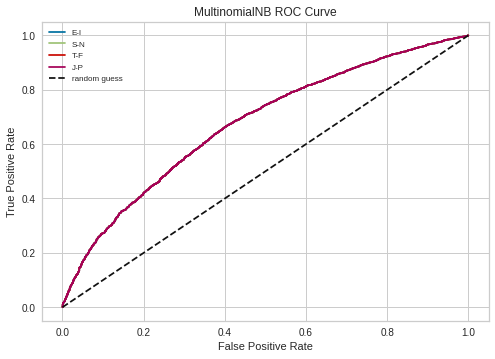

Average f1-score of MultinomialNB :  0.7522872409090123


In [58]:

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    SVC_pipeline.fit(X_train, train[category])
    prediction = SVC_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='weighted')
    total_score += score
    print('f1_score is {}'.format(score))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    # fpr, tpr, thresholds = roc_curve(train[category], SVC_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

# plt.plot([0, 1], [0, 1], 'k--', label="random guess")
# plt.legend(fontsize = 8)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('MultinomialNB ROC Curve')
# plt.show()

# print('Average f1-score of MultinomialNB : ', total_score/4)

... Processing E-I
f1_score is 0.7053756937296759
              precision    recall  f1-score   support

           0       0.47      0.06      0.11       382
           1       0.79      0.98      0.87      1353

    accuracy                           0.78      1735
   macro avg       0.63      0.52      0.49      1735
weighted avg       0.72      0.78      0.71      1735

... Processing S-N
f1_score is 0.7932491381316341
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       246
           1       0.86      1.00      0.92      1489

    accuracy                           0.86      1735
   macro avg       0.55      0.50      0.47      1735
weighted avg       0.77      0.86      0.79      1735

... Processing T-F
f1_score is 0.7164245321982731
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       798
           1       0.73      0.76      0.74       937

    accuracy                    

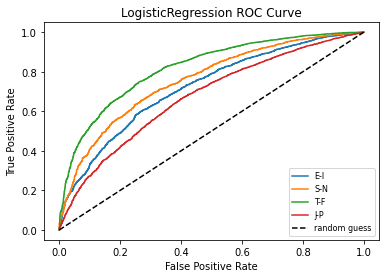

Average f1-score of LogisticRegression :  0.7018348376147274


In [44]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=200)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    LogReg_pipeline.fit(X_train, train[category])
    prediction = LogReg_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='weighted')
    total_score += score
    print('f1_score is {}'.format(score))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], LogReg_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression ROC Curve')
plt.show()

print('Average f1-score of LogisticRegression : ', total_score/4)

In [59]:
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

... Processing E-I
f1_score is 0.6930575921615352
              precision    recall  f1-score   support

           0       0.45      0.03      0.05       382
           1       0.78      0.99      0.87      1353

    accuracy                           0.78      1735
   macro avg       0.62      0.51      0.46      1735
weighted avg       0.71      0.78      0.69      1735

... Processing S-N
f1_score is 0.7927292424968357
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.86      1.00      0.92      1489

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.74      0.86      0.79      1735



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


... Processing T-F
f1_score is 0.7046575053018052
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       798
           1       0.71      0.76      0.74       937

    accuracy                           0.71      1735
   macro avg       0.70      0.70      0.70      1735
weighted avg       0.71      0.71      0.70      1735

... Processing J-P
f1_score is 0.5611135429754858
              precision    recall  f1-score   support

           0       0.50      0.20      0.28       669
           1       0.63      0.87      0.74      1066

    accuracy                           0.61      1735
   macro avg       0.57      0.54      0.51      1735
weighted avg       0.58      0.61      0.56      1735



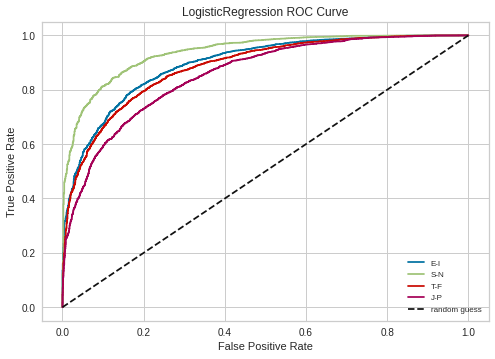

Average f1-score of XGBClassifier :  0.6878894707339154


In [62]:
XGB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=200)),
                ('clf', OneVsRestClassifier(xgb.XGBClassifier(), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    XGB_pipeline.fit(X_train, train[category])
    prediction = XGB_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='weighted')
    total_score += score
    print('f1_score is {}'.format(score))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], XGB_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression ROC Curve')
plt.show()

print('Average f1-score of XGBClassifier : ', total_score/4)

... Processing E-I
f1_score is 0.714629865211855
              precision    recall  f1-score   support

           0       0.42      0.11      0.18       382
           1       0.79      0.96      0.87      1353

    accuracy                           0.77      1735
   macro avg       0.60      0.53      0.52      1735
weighted avg       0.71      0.77      0.71      1735

... Processing S-N
f1_score is 0.7959830216047495
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       246
           1       0.86      1.00      0.92      1489

    accuracy                           0.86      1735
   macro avg       0.68      0.51      0.47      1735
weighted avg       0.81      0.86      0.80      1735

... Processing T-F
f1_score is 0.695959370700929
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       798
           1       0.69      0.82      0.75       937

    accuracy                      

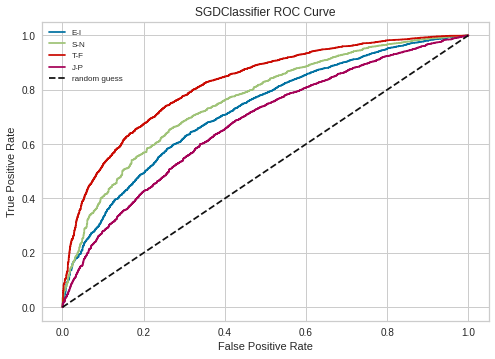

Average f1-score of SGDClassifier :  0.7013240136923204


In [66]:
SGDClassifier_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=200)),
                ('clf', OneVsRestClassifier(SGDClassifier(loss='log'), n_jobs=1)),
            ])
total_score = 0
for category in categories:
    print('... Processing {}'.format(category))

    SGDClassifier_pipeline.fit(X_train, train[category])
    prediction = SGDClassifier_pipeline.predict(X_test)
    score = f1_score(test[category], prediction, average='weighted')
    total_score += score
    print('f1_score is {}'.format(score))

    # print(confusion_matrix(test[category], prediction))
    print(classification_report(test[category], prediction, target_names=['0', '1']))

    fpr, tpr, thresholds = roc_curve(train[category], SGDClassifier_pipeline.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, '-', label=category)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.legend(fontsize = 8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGDClassifier ROC Curve')
plt.show()

print('Average f1-score of SGDClassifier : ', total_score/4)

In [ ]:
somin_text=[" I am studying computer programming and statistics at Sejong University to become a big data analyst (data scientist). Since the department was newly established in 2017, there is no established curriculum and there is no seniors. In addition, there are many times when we do not know how to study. However, during my three semesters I had a certain sense of enlightenment. I want to become as data scientist by studying my magor and I have to be proficient in English to achieve my dream. When I attended a seminar at NC-soft Company, I wanted to work in a foreign country. I have heard that Korea's data scientists do not have their own roles and are doing various things in various fields. It is because big data field did not develop in Korea. And beacause of the ‘protection law’ on personal information leakage, I think that this field will not grow under the policy of Korea, which can not even collect data, which is the most basic step of data analysis. So I decided to go abroad to become a real data scientist. I also made the same commitment when I took an introduction to data analysis in English. When I did not know the concept, I studied with internet search, and all the materials and Youtube lectures were in English. So I had difficulty taking this course. Through this, I once again felt the need for English. I spent two years studying at school and thought that English should be the foundation for me to learn my major deeply and surely. So I decided that I would become more familiar with English through exchange students and would be very helpful for future foreign entry. There are two reasons to go to the The Hague University of Applied Sciences in the Netherlands through the exchange student program. One of that the English level of the European countries 2-3 ranking well. Statistically, Dutch people overestimate their English skills. They have a high level of confidence in English and think that I can not speak English perfectly because I am a foreigner. It is the opposite of Korea, which it is better not to say it because of poor pronunciation or lack of confidence in English ability. In this free environment, I want to assimilate with the Dutch and increase my confidence in English. The other reason is that there is a curriculum that allows students to experience their majors in practice. Taking the APPLIED DATA SCIENCE HBO-ICT course at The Hague University, a team of 6-8 students and an experienced data scientist conducts a project on data science research for half the semester. The other half is about learning about data science, machine learning, Python laptops, and so on. This curriculum has become very attractive. The job of DataScientist is promising, but I always wondered what it does in practice because of lack of relevant information and history. However, if I complete the APPLIED DATA SCIENCE HBO-ICT curriculum, which can not be done at Sejong University, I can solve my questions and dreams will become concrete. For this reason, I would like to be selected for the exchange student program at the The Hague University of Applied Sciences in the Netherlands and to be proud of the school."]

In [ ]:
for category in categories:
    print('... Processing {}'.format(category))
    # X_train_over, y_train_over = smote.fit_sample(X_train, train[category])
    NB_pipeline.fit(X_train, train[category])
    prediction = NB_pipeline.predict(X_test)

... Processing I-E
... Processing N-S
... Processing F-T
... Processing J-P
